# Customer Churn - Feature Engineering

Let's implement some feature engineering to enhance model training.

In [29]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [30]:
# configure visuals
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Current State of the data

In [31]:
# take a look at our data
df = pd.read_csv('backend/data/processed/customer_churn_clean.csv')
print("\nDataset shape:", df.shape)
df.head()



Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-vhveg,female,0,1,0,1,0,0,dsl,0,1,0,0,0,0,month-to-month,1,electronic check,29.850,29.850,0
1,5575-gnvde,male,0,0,0,34,1,0,dsl,1,0,1,0,0,0,one year,0,mailed check,56.950,1889.500,0
2,3668-qpybk,male,0,0,0,2,1,0,dsl,1,1,0,0,0,0,month-to-month,1,mailed check,53.850,108.150,1
3,7795-cfocw,male,0,0,0,45,0,0,dsl,1,0,1,1,0,0,one year,0,bank transfer (automatic),42.300,1840.750,0
4,9237-hqitu,female,0,0,0,2,1,0,fiber optic,0,0,0,0,0,0,month-to-month,1,electronic check,70.700,151.650,1


In [32]:
# drop customer id column as it doesn't provide and valuable information
df = df.drop(columns=['customerID', 'SeniorCitizen', 'Partner', 'Dependents', 'gender'])


In [33]:
# clean some of the values up..
# remove spaces
df['InternetService'] = df['InternetService'].str.split().str.join('')
df['Contract'] = df['Contract'].str.split().str.join('')
df['PaymentMethod'] = df['PaymentMethod'].str.split().str.join('')


# One-Hot Encoding

One-hot encoding can help translate categorical values into a set of indicator values in which the model can use to identity more complex relationships between features

let's take a look at some of the features in which we can apply one-hot encoding:
* InternetService
* Contract
* PaymentMethod

In [34]:
# one hot encoder
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

# encode with OneHotEncoder from sklearn
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorical_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# add columns to previous df
df_new = pd.concat([df, one_hot_df], axis=1)

# drop the old categorical columns
df_new = df_new.drop(categorical_cols, axis=1)

# check my work
df_new.head()
df_new.info()

['InternetService', 'Contract', 'PaymentMethod']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7043 non-null   int64  
 1   PhoneService                           7043 non-null   int64  
 2   MultipleLines                          7043 non-null   int64  
 3   OnlineSecurity                         7043 non-null   int64  
 4   OnlineBackup                           7043 non-null   int64  
 5   DeviceProtection                       7043 non-null   int64  
 6   TechSupport                            7043 non-null   int64  
 7   StreamingTV                            7043 non-null   int64  
 8   StreamingMovies                        7043 non-null   int64  
 9   PaperlessBilling                       7043 non-null   int64  
 10  MonthlyCharges         

In [35]:
df_new.rename(columns={
    "Contract_month-to-month": "Contract_month_to_month", 
    "PaymentMethod_banktransfer(automatic)": "PaymentMethod_banktransfer",
    "PaymentMethod_creditcard(automatic)": "PaymentMethod_creditcard"}, inplace=True)

In [36]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tenure                         7043 non-null   int64  
 1   PhoneService                   7043 non-null   int64  
 2   MultipleLines                  7043 non-null   int64  
 3   OnlineSecurity                 7043 non-null   int64  
 4   OnlineBackup                   7043 non-null   int64  
 5   DeviceProtection               7043 non-null   int64  
 6   TechSupport                    7043 non-null   int64  
 7   StreamingTV                    7043 non-null   int64  
 8   StreamingMovies                7043 non-null   int64  
 9   PaperlessBilling               7043 non-null   int64  
 10  MonthlyCharges                 7043 non-null   float64
 11  TotalCharges                   7043 non-null   float64
 12  Churn                          7043 non-null   i

# Binning

During the EDA process, we were able to identify an opportunity to continuous, numerical data into categorical features. 

Let's revisit the histogram of the **MonthlyCharges** feature:

### Monthly Charges to Package Tier

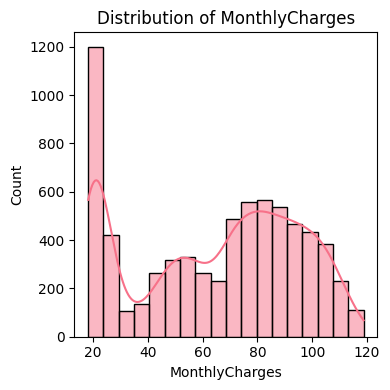

In [37]:
plt.figure(figsize=(4,4))
sns.histplot(data=df_new,x=df_new['MonthlyCharges'],kde=True).set_title("Distribution of MonthlyCharges")
plt.tight_layout()
plt.show()

From the histogram, we can see three clear peaks:
* First peak is between 0 - 30 
* Second peak between 31 - 70
* Third peak between 71 - 100

In [38]:
# define our bins
bins = [0, 30, 70, 100, 120]

"""
    mapping our labels to numeric values
    1 - Basic
    2 - Mid-Tier
    3 - Premium
    4 - High-End
"""
bin_labels = ['basic', 'mid_tier', 'premium', 'high_end']

df_new['PackageTier'] = pd.cut(df_new['MonthlyCharges'], bins=bins, labels=bin_labels)

df_new.head()

,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_dsl,InternetService_fiberoptic,InternetService_no,Contract_month_to_month,Contract_oneyear,Contract_twoyear,PaymentMethod_banktransfer,PaymentMethod_creditcard,PaymentMethod_electroniccheck,PaymentMethod_mailedcheck,PackageTier
0,1,0,0,0,1,0,0,0,0,1,29.850,29.850,0,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,basic
1,34,1,0,1,0,1,0,0,0,0,56.950,1889.500,0,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,mid_tier
2,2,1,0,1,1,0,0,0,0,1,53.850,108.150,1,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,mid_tier
3,45,0,0,1,0,1,1,0,0,0,42.300,1840.750,0,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,mid_tier
4,2,1,0,0,0,0,0,0,0,1,70.700,151.650,1,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,premium


### Tenure to Customer Type

In [39]:
max_tenure = df_new['tenure'].max().astype('int64')
month_bin = [0, 12, 36, max_tenure]
"""
    logic behind bins for months:

    0-12 - NewCustomer
    13-36 - 1_to_3yr_Customer
    37+ - 3_plus_Customer

"""

month_bin_label = ['new_customer','1_to_3yr_customer','3_plus_customer']
df_new['TenureCategory'] = pd.cut(df_new['tenure'], bins=month_bin, labels=month_bin_label, include_lowest=True)

df_new.head()

,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_dsl,InternetService_fiberoptic,InternetService_no,Contract_month_to_month,Contract_oneyear,Contract_twoyear,PaymentMethod_banktransfer,PaymentMethod_creditcard,PaymentMethod_electroniccheck,PaymentMethod_mailedcheck,PackageTier,TenureCategory
0,1,0,0,0,1,0,0,0,0,1,29.850,29.850,0,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,basic,new_customer
1,34,1,0,1,0,1,0,0,0,0,56.950,1889.500,0,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,mid_tier,1_to_3yr_customer
2,2,1,0,1,1,0,0,0,0,1,53.850,108.150,1,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,mid_tier,new_customer
3,45,0,0,1,0,1,1,0,0,0,42.300,1840.750,0,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,mid_tier,3_plus_customer
4,2,1,0,0,0,0,0,0,0,1,70.700,151.650,1,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,premium,new_customer


In [40]:
category_cols = df_new.select_dtypes(include=['category']).columns.tolist()
print(category_cols)

['PackageTier', 'TenureCategory']


In [41]:
# one hot encode the new columns created
category_cols = df_new.select_dtypes(include=['category']).columns.tolist()
new_one_hot_encoded = encoder.fit_transform(df_new[category_cols])
new_one_hot_df = pd.DataFrame(new_one_hot_encoded, columns=encoder.get_feature_names_out(category_cols))

# add columns to previous df
df_new = pd.concat([df_new, new_one_hot_df], axis=1)

# drop the old categorical columns
df_new = df_new.drop(category_cols, axis=1)

df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   tenure                            7043 non-null   int64  
 1   PhoneService                      7043 non-null   int64  
 2   MultipleLines                     7043 non-null   int64  
 3   OnlineSecurity                    7043 non-null   int64  
 4   OnlineBackup                      7043 non-null   int64  
 5   DeviceProtection                  7043 non-null   int64  
 6   TechSupport                       7043 non-null   int64  
 7   StreamingTV                       7043 non-null   int64  
 8   StreamingMovies                   7043 non-null   int64  
 9   PaperlessBilling                  7043 non-null   int64  
 10  MonthlyCharges                    7043 non-null   float64
 11  TotalCharges                      7043 non-null   float64
 12  Churn 

# Creating New Features

In [42]:
# creating a new feature the identify how many services a customer has

# list of the services 
services = df_new[['PaperlessBilling', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'MultipleLines', 'PhoneService', 'InternetService_dsl', 'InternetService_fiberoptic']]

# store the counts of each of services in a new column
df_new['count_of_services'] = df_new[services.columns].apply(lambda row: row.value_counts().get(1,0), axis=1)

# check my work
df_new.head()

,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_dsl,InternetService_fiberoptic,InternetService_no,Contract_month_to_month,Contract_oneyear,Contract_twoyear,PaymentMethod_banktransfer,PaymentMethod_creditcard,PaymentMethod_electroniccheck,PaymentMethod_mailedcheck,PackageTier_basic,PackageTier_high_end,PackageTier_mid_tier,PackageTier_premium,TenureCategory_1_to_3yr_customer,TenureCategory_3_plus_customer,TenureCategory_new_customer,count_of_services
0,1,0,0,0,1,0,0,0,0,1,29.850,29.850,0,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,3
1,34,1,0,1,0,1,0,0,0,0,56.950,1889.500,0,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,4
2,2,1,0,1,1,0,0,0,0,1,53.850,108.150,1,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,5
3,45,0,0,1,0,1,1,0,0,0,42.300,1840.750,0,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,4
4,2,1,0,0,0,0,0,0,0,1,70.700,151.650,1,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,3


In [43]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   tenure                            7043 non-null   int64  
 1   PhoneService                      7043 non-null   int64  
 2   MultipleLines                     7043 non-null   int64  
 3   OnlineSecurity                    7043 non-null   int64  
 4   OnlineBackup                      7043 non-null   int64  
 5   DeviceProtection                  7043 non-null   int64  
 6   TechSupport                       7043 non-null   int64  
 7   StreamingTV                       7043 non-null   int64  
 8   StreamingMovies                   7043 non-null   int64  
 9   PaperlessBilling                  7043 non-null   int64  
 10  MonthlyCharges                    7043 non-null   float64
 11  TotalCharges                      7043 non-null   float64
 12  Churn 

# Correlation Matrix

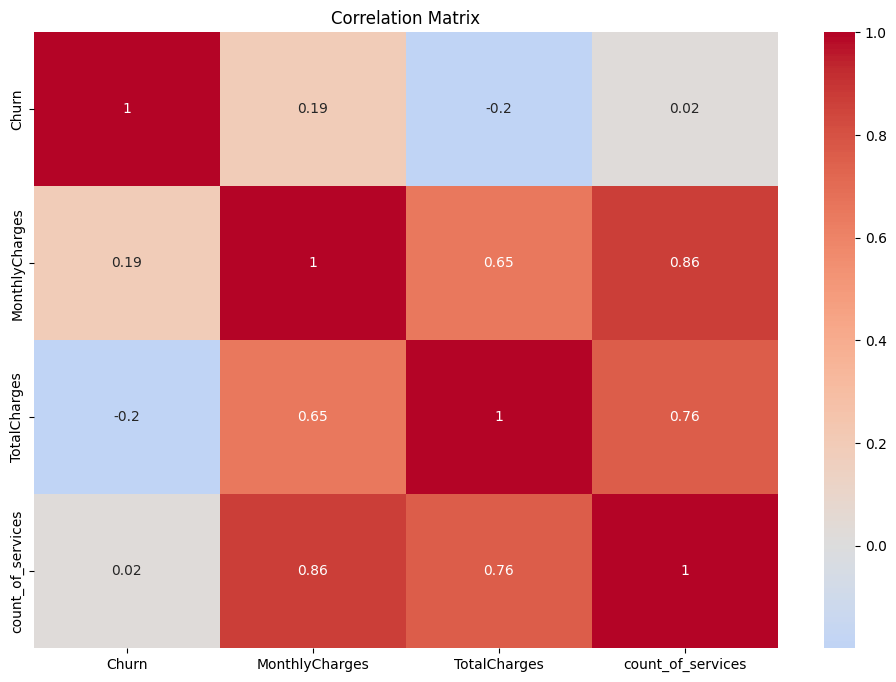

In [44]:
numerical_df = df_new[['Churn','MonthlyCharges','TotalCharges', 'count_of_services']]
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0).set_title('Correlation Matrix')
plt.show()

# Save dataset

In [45]:
# save data
df_new.to_csv('backend/data/processed/customer_churn_fe.csv', index=False)
print("\nCleaned data saved to 'backend/data/processed/customer_churn_fe.csv'")


Cleaned data saved to 'backend/data/processed/customer_churn_fe.csv'
